In [1]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa

In [2]:
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

import operator

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [4]:
%matplotlib inline

## Работа с БД sqlite, создание дополнительных индексов

In [5]:
!ls ../

data  notebooks  Презентация


In [6]:
# создание коннекта к БД и крурсора для запросов
conn = sqlite3.connect('../data/input/hse_sqlite')
c = conn.cursor()

# создание engine для чтения данных в DataFrame
engine = sa.create_engine('sqlite:///../data/input/hse_sqlite.db')

In [7]:
# пример получения перечня таблиц (в данном случае она будет 1)
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print ('Перечень таблиц: {0}\r\n\r\n'.format(c.fetchall()))

# перечень столбцов
c.execute("SELECT * FROM rsa_event_log LIMIT 1;")
cols = [descr[0] for descr in c.description]
print ('Столбцы в таблице: {0}'.format(cols))

Перечень таблиц: [('rsa_event_log',)]


Столбцы в таблице: ['cdf_s_123', 'cdf_s_124', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126', 'cdf_s_133', 'cdf_s_136', 'cdf_s_137', 'cdf_s_140', 'cdf_s_178_hashed', 'cdf_s_19', 'cdf_s_20', 'cdf_s_218', 'cdf_s_294', 'cdf_s_299', 'amount_original', 'channel_indicator_desc', 'custom_mark', 'data_i_118', 'data_i_119', 'data_i_120', 'data_i_154', 'data_s_65', 'event_description', 'event_id', 'event_time', 'ext_acct_number_hashed', 'hardwareid', 'short_date', 'user_acct_number_hashed', 'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash', 'user_id', 'ip_address', 'ip_country', 'ip_region', 'ip_city', 'ip_isp']


### Подробнее что есть что

'event_id'- уникальный id транзакции

'short_date' - дата (для удобства поиска/агрегации)

'user_id' - уникальный идентификатор клиента

'event_time' - дата и время собятия

'custom_mark'- результат разбора события

'channel_indicator_desc' - канал проведения операции (web, мобильное приложение, SMS-банк и пр.)

'event_description' - описание непосредственно события (например, вход в систему или перевод, оплата услуг)

'amount_original' - сумма в рублях

'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash' - различные признаки устройства (с определенной степенью точности позволяет понять уникальность устройства в разрезе пользователя)

ip_address', 'ip_country', 'ip_region', 'ip_city', 'ip_isp' - данные, связанные с IP (регион, город и интернет-провадйер по БД гео-IP)
'hardwareid' - уникальный идентификатор устройства для канала мобильных приложений

'user_acct_number_hashed'- счет отправителя (хэшированный)
'ext_acct_number_hashed'- счет получателя (хэшированный)


'data_s_65' - результат определения связи между отправителем и получателем (чем больше, тем сильнее связь) 
'data_i_118', 'data_i_119’, 'data_i_120', 'data_i_154' - ряд признаков, которые описывают устройство, с которого проводятся операции
 


 'cdf_s_136','cdf_s_137','cdf_s_140'- кумулятивные суммы операций за сутки в web, МП, web + МП
 'cdf_s_218'- предполагаемое наличие родственной связи 
 'cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126' - дней с момента различных рисковых событий



 'cdf_s_19'- ДР клиента
 'cdf_s_20'- Территориальный банк клиента (региональный признак)
 'cdf_s_299'- Тер банк получателя (региональный признак)

 'cdf_s_294'- возраст получателя

 'cdf_s_123'- региональный признак получателя (более локальный по сравнению с ТБ)
 'cdf_s_124'- дата выдачи карты получателя

 'cdf_s_178_hashed' - реквизит получателя

In [8]:
# функция получения lable из csutom_mark

def cust_mark_to_class(custom_mark):
    """
    Преобразует входящее значение CUSTOM_MARK в класс
    return:
        1 - фрод
        0 - легитимная
        -1 - неизвестно
    """
    ret = -1
    if custom_mark in ['F','S']:
        ret = 1
    elif custom_mark in ['A','G', np.NaN]:
        ret = 0
    
    return ret

In [9]:
# Пример форомирования DataFrame из БД с заполнением типа полей

def transform_cols (df, dict_col_types = None):
    # Расширяйте для необходимых столбцов и их явной типизации
    if dict_col_types is None:
        dict_col_types = {
        'amount_original':(float, 0.0),
        'cdf_s_126':(str, u'null'),
        'cdf_s_138':(str, u'null'),
        'channel_indicator':(str, u'null'),
        'event_description':(str, u'null'),
        'cdf_s_294':(int, 0),
        'cdf_s_140':(float, 0.0),
        'data_i_120':(int, 0),
        'cdf_s_218':(str, u'null'),
        'data_s_65':(int, 0),
        'cdf_s_127':(int, 30),
        'cdf_s_135':(int, 30),
        'cdf_s_130':(int, 30),
        'cdf_s_129':(int, 30),
        'cdf_s_134':(int, 30),
        'data_i_154':(float, np.nan),
        'cdf_s_133':(int, 30),
        'cdf_s_20':(str, u'null'),
        'cdf_s_299':(str, u'null'),
        }
                
    if df.shape[0] > 0:
        df.replace(u'null', np.nan, inplace=True)

        for i in dict_col_types:
            if i in df.columns:
                df[i] = df[i].fillna(dict_col_types[i][1]).astype(dict_col_types[i][0])
    
    return df
    

def df_from_sql (sql, parse_dates = ['event_time','cdf_s_19', 'cdf_s_123','cdf_s_124'], dict_col_types = None, chunk_size = None, engine=engine):
    """
    Функция вощвращающая df в результате переданного sql-запроса
    Также поддерживается приведение столбцов к заданным типам 
    и чтение по блокам
    """
     
    if chunk_size is not None:
        df_iter =  [transform_cols(chunk, dict_col_types) for chunk in pd.read_sql_query(sql, engine, parse_dates = parse_dates, chunksize=chunk_size)]
    else:
        df_iter = transform_cols(pd.read_sql_query(sql, engine, parse_dates = parse_dates), dict_col_types)
        #df_iter = pd.read_sql_query(sql, engine, con=conn,  parse_dates = parse_dates)
    
    return df_iter


Я тут по факту продублировал индексы.

In [10]:
# создание индексов для ускорения поиска
# описанные здесь уже созданы в предоставленной БД, при необходимотси можете расширить набор
cols_to_index = ['user_id', 'custom_mark', 'short_date',  'channel_indicator_desc', 'event_description']

for col in cols_to_index:
    c.execute('CREATE INDEX {ix} on {tn}({cn})'\
            .format(ix='indx_new_{0}'.format(col), tn='rsa_event_log', cn=col)) # add new index indx_new_{0}

c.execute('CREATE INDEX date_user_event on rsa_event_log(short_date, user_id, event_description);')   
    
conn.commit()

OperationalError: index indx_new_user_id already exists

In [11]:
#  Общий срез по данным
c.execute("select COUNT(*) from rsa_event_log;")
print ('Общее число транзакций: {0}'.format(c.fetchall()))


# Число уникальных пользователей
c.execute("select COUNT(DISTINCT user_id) from rsa_event_log;")
print ("Уникальных пользователей: {0}".format(c.fetchall()))

# Временной диапазон и количество клиентов
c.execute("select min(short_date), max(short_date) from rsa_event_log;")
print('Диапазон дат: {0}'.format(c.fetchall()))


Общее число транзакций: [(70406114,)]
Уникальных пользователей: [(194704,)]
Диапазон дат: [(20170415, 20171204)]


In [12]:
c.execute("select COUNT(*) from rsa_event_log;")
print ('Общее число транзакций: {0}'.format(c.fetchall()))

Общее число транзакций: [(70406114,)]


###  Summary анализ данных (на примере 5% выборки пользователей)
1) Общее число записей и столбцов

2) Типы данных, numeric, categorical, распределения, число уникальных типов

3) Вариативность и NULL

In [13]:
all_users = df_from_sql('select DISTINCT user_id from rsa_event_log;',
                        engine=conn,
                        parse_dates=None)

In [14]:
sample_users = all_users.sample(frac=0.05).user_id.astype(str).tolist()

In [15]:
# достаточно долгий запрос
data = df_from_sql("select * from rsa_event_log where user_id in ({0});".format(str(sample_users)[1:-1]), engine=conn)

In [20]:
%%time
data.to_csv('../data/data1per.tsv', sep = '\t')

CPU times: user 50.9 s, sys: 712 ms, total: 51.6 s
Wall time: 52.3 s


In [21]:
%%time
data.to_pickleckle('../data/data1per.pkl')

CPU times: user 12.8 s, sys: 1.76 s, total: 14.6 s
Wall time: 15.2 s


In [ ]:
%%time
data.to_csv('../data/data1per.tsv', sep = '\t')

In [20]:
!ls ../

data  notebooks


In [23]:
data = pd.read_csv('../data/data1per.csv', index_col=0)

/home/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/alex/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [24]:
print ('Shape: {0}'.format(data.shape))
data.head(10)

Shape: (3396348, 44)


cdf_s_123 cdf_s_124  cdf_s_127  cdf_s_135  cdf_s_130  cdf_s_129  cdf_s_134  \
0  NaN       NaN       30         1          30         30         4           
1  NaN       NaN       30         4          30         30         4           
2  NaN       NaN       30         5          30         30         30          
3  NaN       NaN       30         0          30         30         30          
4  NaN       NaN       30         30         30         30         0           
5  NaN       NaN       30         30         30         30         4           
6  NaN       NaN       30         30         30         30         30          
7  NaN       NaN       30         30         30         30         5           
8  NaN       NaN       30         2          2          30         30          
9  NaN       NaN       30         30         30         30         30          

   cdf_s_128 cdf_s_138 cdf_s_126  cdf_s_133  cdf_s_136  cdf_s_137  cdf_s_140  \
0 NaN         null      null      30        NaN        NaN         0.0         
1 NaN         null      null      30        NaN        NaN         0.0         
2 NaN         null      null      30        NaN        NaN         0.0         
3 NaN         null      null      30        NaN        NaN         0.0         
4 NaN         null      null      30        NaN        NaN         0.0         
5 NaN         null      null      30        NaN        NaN         0.0         
6 NaN         null      null      30        NaN        NaN         0.0         
7 NaN         null      null      30        NaN        NaN         0.0         
8 NaN         НЕТ       ДА        30        NaN        NaN         0.0         
9 NaN         null      null      30        NaN        NaN         0.0         

  cdf_s_178_hashed             cdf_s_19 cdf_s_20 cdf_s_218  cdf_s_294  \
0  NaN              1989-11-18 00:00:00  99       null      0           
1  NaN              1989-11-18 00:00:00  99       null      0           
2  NaN              1989-11-18 00:00:00  99       null      0           
3  NaN              1989-11-18 00:00:00  99       null      0           
4  NaN              1989-11-18 00:00:00  99       null      0           
5  NaN              1989-11-18 00:00:00  99       null      0           
6  NaN              1989-11-18 00:00:00  99       null      0           
7  NaN              1989-11-18 00:00:00  99       null      0           
8  NaN              1989-11-18 00:00:00  99       null      0           
9  NaN              1989-11-18 00:00:00  99       null      0           

  cdf_s_299  amount_original channel_indicator_desc custom_mark  data_i_118  \
0  null      0.0              MOBILEAPI              NaN         1.0          
1  null      0.0              MOBILEAPI              NaN         1.0          
2  null      0.0              MOBILEAPI              NaN         1.0          
3  null      0.0              MOBILEAPI              NaN         1.0          
4  null      0.0              MOBILEAPI              NaN         1.0          
5  null      0.0              MOBILEAPI              NaN         1.0          
6  null      0.0              MOBILEAPI              NaN         1.0          
7  null      0.0              MOBILEAPI              NaN         1.0          
8  null      550.0            MOBILEAPI              NaN         1.0          
9  null      0.0              MOBILEAPI              NaN         1.0          

   data_i_119  data_i_120  data_i_154  data_s_65  \
0  1.0         1           27.0        0           
1  1.0         1           42.0        0           
2  1.0         1           442.0       0           
3  1.0         1           85.0        0           
4  1.0         1           382.0       0           
5  1.0         1           60.0        0           
6  1.0         1           65.0        0           
7  1.0         1           55.0        0           
8  1.0         1           116.0       182         
9  1.0         1           346.0       0      

In [25]:
#Сводная статистика по датасету


def summary_stats(data):
    df_summary_stats = pd.DataFrame(index=data.columns,columns=['type','nunique', 'top_3_values_freq', 'null_rate', 'std','min', 'max', 'mean', 'quantile'])
    for col in data.columns:

        col_type = data[col].dtype
        if col_type in ['object','str']:
            df_summary_stats.loc[col][[
                'type',
                'nunique', 
                'top_3_values_freq', 
                'null_rate'
            ]] = \
            col_type, \
            data[col].nunique(),\
            dict(data[col].value_counts().head(3)*100.0/data.shape[0]),\
            sum(data[col].isnull())*100.0/data.shape[0]

        if col_type in ['int64', 'float64', 'int32', 'float32']:
            df_summary_stats.loc[col][[
                'type',
                'null_rate',
                'std',
                'min',
                'max',
                'mean',
                'quantile'
            ]] = \
            col_type, \
            sum(data[col].isnull())*100.0/data.shape[0],\
            data[col].std(),\
            data[col].min(),\
            data[col].max(),\
            data[col].mean(),\
            dict(data[col].quantile([0.25,0.5,0.75]))

        if col_type == 'datetime64[ns]':
            df_summary_stats.loc[col][[
                'type',
                'null_rate',
                'min',
                'max',
            ]] = \
            col_type, \
            sum(data[col].isnull())*100.0/data.shape[0],\
            data[col].min(),\
            data[col].max()
        
    return df_summary_stats

In [26]:
# Обратите внимание, что у многих столбцов тип определился как object (исключая заданные нами) - обычно такое бывает когда столбец содержит Nan или же не был определен тип данных (например, для строк)
summary_stats(data)

type  nunique  \
cdf_s_123                object   12431     
cdf_s_124                object   4219      
cdf_s_127                int64    NaN       
cdf_s_135                int64    NaN       
cdf_s_130                int64    NaN       
cdf_s_129                int64    NaN       
cdf_s_134                int64    NaN       
cdf_s_128                float64  NaN       
cdf_s_138                object   3         
cdf_s_126                object   3         
cdf_s_133                int64    NaN       
cdf_s_136                float64  NaN       
cdf_s_137                float64  NaN       
cdf_s_140                float64  NaN       
cdf_s_178_hashed         object   39404     
cdf_s_19                 object   7415      
cdf_s_20                 object   584       
cdf_s_218                object   3         
cdf_s_294                int64    NaN       
cdf_s_299                object   16        
amount_original          float64  NaN       
channel_indicator_desc   object   10        
custom_mark              object   4         
data_i_118               float64  NaN       
data_i_119               float64  NaN       
data_i_120               int64    NaN       
data_i_154               float64  NaN       
data_s_65                int64    NaN       
event_description        object   112       
event_id                 object   3396348   
event_time               object   2988414   
ext_acct_number_hashed   object   275746    
hardwareid               object   11806     
short_date               int64    NaN       
user_acct_number_hashed  object   23940     
user_agent_string_hash   object   4360      
browser_plugins_hash     object   3314      
screen_hash              object   943       
user_id                  object   9736      
ip_address               object   219715    
ip_country               object   103       
ip_region                object   166       
ip_city                  object   2336      
ip_isp                   float64  NaN       

                                                                                                                                                                                                top_3_values_freq  \
cdf_s_123                {'2017-05-25 00:00:00': 0.00847969642687, '2017-07-03 00:00:00': 0.00680142317572, '2017-06-27 00:00:00': 0.00635977232015}                                                                
cdf_s_124                {'2016-12-02 00:00:00': 0.00951021508986, '2017-10-23 00:00:00': 0.00883301711132, '2017-10-17 00:00:00': 0.00853858320761}                                                                
cdf_s_127                NaN                                                                                                                                                                                        
cdf_s_135                NaN                                                                                                                                                                                        
cdf_s_130                NaN                                                                                                                                                                                        
cdf_s_129                NaN                                                                                                                                                                                        
cdf_s_134                NaN                                                                                                                                                                                        
cdf_s_128                NaN                                                                                                                                                                                        
cdf_s_138                {'null': 72.4223489466, 'НЕТ': 26.4797659133, 'ДА': 1.097885

In [27]:
#Типы операций
data.event_description.value_counts(dropna=False)

Вход в систему с одноразовым паролем                                                                     1483772
Перевод частному лицу                                                                                    475672 
Просмотр документа                                                                                       445331 
Оплата услуг                                                                                             327770 
Перевод между своими счетами и картами                                                                   202412 
Вход в систему без одноразового пароля                                                                   89627  
Неуспешный вход в систему                                                                                54757  
MobileOffer                                                                                              51039  
mP2P                                                                                            

### Постановка задачи - разработка модели, осуществляющей выявление мошенничество в каналах WEBAPI, MOBILEAPI, ATMAPI

In [28]:
# И тут мы видим лучшую заполненнсоть полей
transaction_data = data[data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
print(transaction_data.shape)
summary_stats(transaction_data)

(1005854, 44)


type  nunique  \
cdf_s_123                object   12431     
cdf_s_124                object   4219      
cdf_s_127                int64    NaN       
cdf_s_135                int64    NaN       
cdf_s_130                int64    NaN       
cdf_s_129                int64    NaN       
cdf_s_134                int64    NaN       
cdf_s_128                float64  NaN       
cdf_s_138                object   3         
cdf_s_126                object   3         
cdf_s_133                int64    NaN       
cdf_s_136                float64  NaN       
cdf_s_137                float64  NaN       
cdf_s_140                float64  NaN       
cdf_s_178_hashed         object   0         
cdf_s_19                 object   7280      
cdf_s_20                 object   14        
cdf_s_218                object   3         
cdf_s_294                int64    NaN       
cdf_s_299                object   16        
amount_original          float64  NaN       
channel_indicator_desc   object   3         
custom_mark              object   4         
data_i_118               float64  NaN       
data_i_119               float64  NaN       
data_i_120               int64    NaN       
data_i_154               float64  NaN       
data_s_65                int64    NaN       
event_description        object   3         
event_id                 object   1005854   
event_time               object   970371    
ext_acct_number_hashed   object   240757    
hardwareid               object   10952     
short_date               int64    NaN       
user_acct_number_hashed  object   22046     
user_agent_string_hash   object   3290      
browser_plugins_hash     object   2518      
screen_hash              object   733       
user_id                  object   9534      
ip_address               object   164954    
ip_country               object   96        
ip_region                object   147       
ip_city                  object   1969      
ip_isp                   float64  NaN       

                                                                                                                                                                                            top_3_values_freq  \
cdf_s_123                {'2017-05-25 00:00:00': 0.0286323860123, '2017-07-03 00:00:00': 0.022965559614, '2017-06-27 00:00:00': 0.0214742895092}                                                                
cdf_s_124                {'2016-12-02 00:00:00': 0.0321120162568, '2017-10-23 00:00:00': 0.0298254020961, '2017-10-17 00:00:00': 0.0288312220263}                                                               
cdf_s_127                NaN                                                                                                                                                                                    
cdf_s_135                NaN                                                                                                                                                                                    
cdf_s_130                NaN                                                                                                                                                                                    
cdf_s_129                NaN                                                                                                                                                                                    
cdf_s_134                NaN                                                                                                                                                                                    
cdf_s_128                NaN                                                                                                                                                                                    
cdf_s_138                {'НЕТ': 88.6694291617, 'null': 7.87470149743, 'ДА': 3.45586934088}                              

In [29]:
data = transaction_data = None

## Feature engineering

### Поскольку объем данных достаточно существенный и одновременно в память его не прогрузить, то необходимо рассчитывать фичи по "порциями". Cплитить будем по пользователям

In [30]:
# сначала определим временной диапазон, в котором будем тренировать и валидировать модель исходя из распределения фрода
fraud_df = df_from_sql("select * from rsa_event_log where custom_mark in ('F','S')", engine=conn)

# основная доля сосредоточена в период с 29.10 по 28.11, его и выбираем
fraud_df.groupby('short_date').event_id.count()

short_date
20170415    3   
20170416    1   
20170418    8   
20170419    11  
20170420    7   
20170422    4   
20170423    8   
20170424    6   
20170426    4   
20170427    21  
20170428    5   
20170429    1   
20170501    4   
20170502    2   
20170503    22  
20170504    5   
20170505    6   
20170506    2   
20170507    1   
20170508    31  
20170509    6   
20170510    20  
20170512    4   
20170513    1   
20170514    20  
20170515    3   
20170516    8   
20170517    11  
20170518    8   
20170519    4   
20170520    12  
20170521    1   
20170522    4   
20170523    6   
20170524    5   
20170528    1   
20170529    6   
20170530    5   
20170531    6   
20170601    17  
20170602    6   
20170603    1   
20170604    3   
20170605    9   
20170606    2   
20170608    3   
20170610    4   
20170611    12  
20170612    2   
20170613    6   
20170614    15  
20170615    5   
20170616    20  
20170617    1   
20170618    20  
20170619    6   
20170620    8   
20170621    2   
201

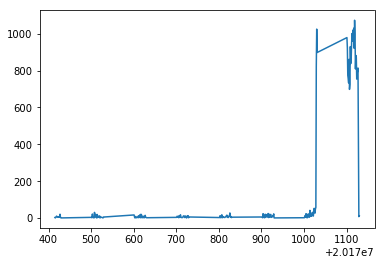

In [31]:
plt.plot(fraud_df.groupby('short_date').event_id.count())
plt.show()

## Обратите внимание на выбор диапазона 

In [34]:
start_date = "20171029"
end_date = "20171128"

In [33]:
# для ускорения проверки корректности расчета фич - используйте sample из 1-2% пользователей
all_users = df_from_sql("select distinct user_id from rsa_event_log", engine=conn,parse_dates=None)
users_sample = all_users.sample(frac=0.01).user_id.astype(str).tolist()

In [35]:
# Функция рассчет по пачкам, если dataset не помещается в память

def features_chunk_handler(sql, calc_feat, chunk_size=5000):
    """
    sql - запрос выбирающий данные и возвращающий df необходимого для calc_feat метода
    calc_feat - процедура, осуществляющая расчет фичей на основании входного DF
    """
    rez_df = pd.DataFrame()
    for chunk in df_from_sql(sql, engine=conn, chunk_size=chunk_size):
        
        # При необходимости - добавить еще запись в БД sqlite рассчитанных признаков
        feat_chunk = calc_feat(chunk)
        #feat_chunk = chunk
        
        rez_df = pd.concat([rez_df, feat_chunk], ignore_index=True)
        
    return rez_df
        

In [36]:
def calc_base_features (data):
    feat_matrix = pd.DataFrame()
    # sampling - data = data[data.user_id.isin(users_sample) & data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
    data = data[data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
    
    if data.shape[0] == 0:
        return feat_matrix
    
    # заполняем ряд пропусков
    data.cdf_s_140 = data.cdf_s_140.fillna(0).astype(float)/1000 # кумулятивная сумма опреаций за сутки, если не заполнена, то значит это первая операций, т.е. = 0
    data.data_i_120.fillna(1, inplace=True)

    
    feat_matrix['event_id'] = data.event_id
    feat_matrix['user_id'] = data.user_id

    feat_matrix['custom_mark'] = data.custom_mark    
    feat_matrix['event_time'] = data.event_time

    feat_matrix['amount'] = data.amount_original
    
    feat_matrix['client_age'] = (data.event_time - data.cdf_s_19).apply(lambda x: x.days/360)
 
        
    feat_matrix['cat_new_ip'] = data.cdf_s_126.apply(lambda x: 1 if x == u'ДА' else 0 if x == u'НЕТ' else 2)
    feat_matrix['cat_new_prov'] = data.cdf_s_138.apply(lambda x: 1 if x == u'ДА' else 0 if x == u'НЕТ' else 2)
    feat_matrix['channel_op'] = data.channel_indicator.apply(lambda x: 0 if x == u'MOBILE' else 1 if x == u'WEB' else 2)
    feat_matrix['op_type'] = data.event_description.apply(lambda x:
            0 if x == u'Перевод частному лицу' else 1 if x==u'Оплата услуг' else 2 if x ==u'Перевод между своими счетами и картами' else 3)


    feat_matrix ['recip_age'] = data.cdf_s_294.apply(lambda x: 1 if x == 0 else 0) # бинарный флаг определяющий наличие возраста получателя (полезен для линейных моделей, менее для деревьев с учетом следующего признака)
    
    
    feat_matrix['age_diff'] = feat_matrix.client_age - data.cdf_s_294.apply(lambda x: int(x) if x != 0 else 1000) # разница возорастов получателей и отправителей, если отсутствует/неприменимо, то padding 500    
  
    
    feat_matrix['cumulative_sum_total'] = data.cdf_s_140 # кумулятивная сумма операций за сутки в каналах web и МП
    
    feat_matrix['data_i_120'] = data.data_i_120 
    
    
    feat_matrix['relative'] = data.cdf_s_218.apply(lambda x: 1 if x == u'ДА' else 0) # перевод родственнику
    
    feat_matrix['know_recip_power'] = data.data_s_65.apply(lambda x: x if x is not None else 0) # сила связи отправителя и получателя
    
    
    feat_matrix['cdf_s_127'] = data.cdf_s_127#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_135'] = data.cdf_s_135#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_130'] = data.cdf_s_130#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_129'] = data.cdf_s_129#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_134'] = data.cdf_s_134#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['data_i_154'] = data.data_i_154.apply(lambda x: x if x is not None else -150)
    feat_matrix['cdf_s_133'] = data.cdf_s_133#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['data_i_120'] = data.data_i_120
    feat_matrix['know_recip_card_age'] = data.cdf_s_124.apply(lambda x: 1 if x is not None else 0)
    
    
    feat_matrix['recip_card_age'] = (data.event_time - data.cdf_s_124).apply(lambda x: x.days if type(x) is not pd.tslib.NaTType else 2000)
    
    feat_matrix['cat_client_region'] = data.cdf_s_20.astype(str)
    feat_matrix['one_region'] = (data.cdf_s_20 == data.cdf_s_299).astype(int) # сравнение регионов
    
    #ADD NEW FEATURES
        
    return feat_matrix

# Задание - реализовать как минимум 7 новых признаков, 3 из которых должны быть обработкой категориальных столбцов

Пример:

Кортежи регионов отправителя и получателя

ISP провайдера

Подсети класса B

### Расчет фичей

In [37]:
sql = """select * from rsa_event_log 
                        where short_date between {start} and {end};""".format(start=start_date, end=end_date)

In [ ]:
st = datetime.datetime.now()
data_ts = df_from_sql(sql, engine=conn)
end = datetime.datetime.now()
print(end - st)

In [ ]:
data_ts.shape

In [ ]:
data_ts.to_csv('./data/feat_matrix_prt1.csv', sep=';', index=False)

In [ ]:
st = datetime.datetime.now()
trans_feat = features_chunk_handler(sql, calc_base_features, 1000000)
end = datetime.datetime.now()
print(end - st)

In [ ]:
trans_feat.to_csv('./data/feat_matrix_prt1.csv', sep=';', index=False)

In [7]:
trans_feat = pd.read_csv('./data/feat_matrix_prt1.csv',sep=';', parse_dates=['event_time'])

In [22]:
trans_feat.shape

(1041634, 27)

In [ ]:
trans_feat.custom_mark.value_counts(dropna=False)

In [23]:
trans_feat.custom_mark.value_counts(dropna=False)

NaN    959573
G      64712 
F      10270 
S      3737  
U      3342  
Name: custom_mark, dtype: int64

### Вспомогательные функции для работы с временнЫми данными

In [25]:
# будем считать данные на ежедневном базисе по квантилям клиента
trans_data = df_from_sql("select * from rsa_event_log where user_id in ({0})".format(str(users_sample)[1:-1]))

In [26]:
# как уже говорились при работе с данными, имеющими временной аспект крайне важно отсекать транзакции, 
# идущие после оцениваемого события

# кроме того зачастую бывает полезно создавать фичи не за весь доступный горизонт данных, 
# а за различные временные окна
def timeframe_trans(trans, date_threshold=None, depth=None):
    """
    Функция отбирающая тразакции в заданном временном окне
    :param trans: весь массив транзакций
    :param date_threshold: дата и время отсечки, если не указан, то datetime.now()
    :param depth: глубина периода от даты отсечки, если не указан, то от текущего момента
    :return:
    
    """
    if date_threshold and depth:
        interested_trans = trans[trans.event_time.between(date_threshold - depth, date_threshold)]
    elif date_threshold and depth is None:
        interested_trans = trans[trans.event_time <= date_threshold]
    elif date_threshold is None and depth:
        interested_trans = trans[trans.event_time.between(datetime.datetime.now() - depth, datetime.datetime.now())]
    else:
        interested_trans = trans

    return interested_trans


def calc_quants_per_user (trans, col_name='amount_original', quants=np.arange(0.1, 1.1, .1), feat_name='amount_q_', depth=None, start_date = datetime.date(2017,10,29), 
                 end_date = datetime.date(2017,11,29)):
    """
    Функция рассчитывающая квантили для пользователя с округлением до дня
    """
    
    time_delta = end_date - start_date
    #можно переопределить и выбрать другой временной интервал
    list_of_days = [start_date + datetime.timedelta(days=i) for i in range(time_delta.days + 1)]
    
    rez_df = pd.DataFrame()
    
    for day in list_of_days:
        if depth is None:
            cur_cutoff = trans[trans.event_time < day]
        else:
            cur_cutoff = trans[(trans.event_time < day)&(trans.event_time > (day - depth))]
            
        if cur_cutoff.shape[0] >= 1:
            res = cur_cutoff[col_name].quantile(quants)
        else:
            res = [0 for i in quants]
    
        for i in zip(quants, res):
            rez_df.loc[day, feat_name + str(i[0])] = i[1]
    
        
    
    return rez_df


def all_usr_quants(users_list, number_of_splits = 900, col_name = 'amount_original', quants=np.arange(0.1, 1.1, .1), feat_name='amount_q_', depth=None, start_date = datetime.date(2017,10,29), 
                 end_date = datetime.date(2017,11,29)):
    """
    Расчет квантилей по всем пользователям со сплитованием на подмножества
    """
    rez_df = pd.DataFrame()
    usr_chunks = np.array_split(users_list, number_of_splits)
    
    for chunk in usr_chunks:
        
        trans_data = df_from_sql("select user_id, event_time, {col} from rsa_event_log where user_id in ({users})".format(col = col_name, users=str(list(chunk))[1:-1]), parse_dates=['event_time'])
        chunk_df =  trans_data.groupby('user_id').apply(lambda x: 
                        # В даннос случае x - dataframe с транзакциями 1ого пользователя
                        calc_quants_per_user(x[x[col_name] <> 0], col_name=col_name, feat_name=feat_name, quants=quants, depth = depth, start_date=start_date, end_date=end_date)
                    )
        rez_df = pd.concat([rez_df, chunk_df])
        
    return rez_df

In [27]:
# Пример как получить транзакции пользователей за 2 недели до их последней транзакции
trans_data[trans_data.user_id.isin(users_sample)].groupby('user_id').apply(lambda x: timeframe_trans(x, x.event_time.max(), depth=datetime.timedelta(days=14))).head(25)

event_id  short_date   user_id  \
user_id                                                               
10179053 0    5065:e0fcee4cf51:aa7c4b12-_TRX   20171116    10179053   
         2    ba44-:8babc4ebf51:dc8ca2e7-_TRX  20171115    10179053   
         3    86b2:06282f4cf51:690b0eb5_TRX    20171116    10179053   
         6    6707-:7896659bf51:f4907ef6-_TRX  20171114    10179053   
         14   5ec1-:7896659bf51:f4907ef6-_TRX  20171114    10179053   
         17   5e11:bae00f4cf51:e30ac344-_TRX   20171116    10179053   
         18   b805-:c578a4ebf51:a87507e2_TRX   20171115    10179053   
         21   6573:c208359bf51:e9a26893_TRX    20171114    10179053   
         22   b886:f2d65cabf51:321f0946_TRX    20171114    10179053   
         24   3785:e0fcee4cf51:aa7c4b12-_TRX   20171116    10179053   
         25   70b-:29fe59ebf51:8082da44_TRX    20171115    10179053   
         29   b2b-:29fe59ebf51:8082da44_TRX    20171115    10179053   
         36   10e1:c208359bf51:e9a26893_TRX    20171114    10179053   
10322754 42   d926-:51db133ff51:3b046184_TRX   20171125    10322754   
         51   d94:d0b94c2ff51:fd1bd117_TRX     20171125    10322754   
         53   a584-:b01c133ef51:dc8ca2e7-_TRX  20171122    10322754   
         58   be27:60c4cb2ff51:e017a6a4_TRX    20171125    10322754   
         75   31b2:1f3ae13ff51:e9a26893_TRX    20171125    10322754   
         105  f9c6:b421f23ff51:8082da44_TRX    20171125    10322754   
         111  8085-:51db133ff51:3b046184_TRX   20171125    10322754   
         118  cbb6:1f5fa270061:e017a6a4_TRX    20171129    10322754   
         122  7912-:83c935ecf51:e9a26893_TRX   20171118    10322754   
         127  fd01-:5f81c4ecf51:e30ac344-_TRX  20171118    10322754   
         133  48a2:dcfdb23ef51:70569b87_TRX    20171122    10322754   
         137  9c63:97ab567df51:8082da44_TRX    20171120    10322754   

                      event_time custom_mark channel_indicator_desc  \
user_id                                                               
10179053 0   2017-11-16 16:17:48  NaN         ATMAPI                  
         2   2017-11-15 09:13:21  G           ATMAPI                  
         3   2017-11-16 16:17:45  NaN         ATMAPI                  
         6   2017-11-14 10:03:42  NaN         ATMAPI                  
         14  2017-11-14 10:08:32  NaN         ATMAPI                  
         17  2017-11-16 16:16:38  NaN         ATMAPI                  
         18  2017-11-15 09:10:49  NaN         ATMAPI                  
         21  2017-11-14 10:08:29  NaN         ATMAPI                  
         22  2017-11-14 16:57:43  NaN         ATMAPI                  
         24  2017-11-16 16:17:57  NaN         ATMAPI                  
         25  2017-11-15 10:35:21  NaN         WEBAPI                  
         29  2017-11-15 10:35:21  NaN         WEBAPI                  
         36  2017-11-14 10:07:12  NaN         ATMAPI                  
10322754 42  2017-11-25 15:42:43  NaN         IVR                     
         51  2017-11-25 13:49:51  G           MOBILEAPI               
         53  2017-11-22 13:09:21  NaN         ATMAPI                  
         58  2017-11-25 13:47:54  NaN         MOBILEAPI               
         75  2017-11-25 15:31:57  NaN         ATMAPI                  
         105 2017-11-25 15:54:43  NaN         CRM                     
         111 2017-11-25 15:43:27  NaN         IVR                     
         118 2017-11-29 12:57:39  NaN         ATMAPI                  
         122 2017-11-18 11:57:59  NaN         ATMAPI                  
         127 2017-11-18 11:52:28  NaN         ATMAPI                  
         133 2017-11-22 13:08:23  NaN         ATMAPI                  
         137 2017-11-20 06:37:14  NaN         MBK                     

                                          event_description  amount_original  \
user_id                                                                        
10179053 0    Просмотр документа         

In [418]:
victims = trans_feat[trans_feat.custom_mark.isin(['F','S'])].user_id.sample(frac=1).astype(str).unique().tolist()
print len(victims)

44919


In [99]:
# Добавляем квантили по операциям клиента за 30 дней до транзакции и 90 дней

# 30 дней
df_30_days = all_usr_quants(all_users.user_id.astype(str).unique().tolist(), number_of_splits=20, col_name="amount_original", depth=datetime.timedelta(days=30), feat_name='amnt_30_q_')

# 90 дней
df_90_days = all_usr_quants(all_users.user_id.astype(str).unique().tolist(), 20, col_name="amount_original", depth=datetime.timedelta(days=90), feat_name='amnt_90_q_')

In [100]:
quant_features = pd.merge(df_30_days, df_90_days, left_index=True, right_index=True)
quant_features.reset_index(inplace=True)
quant_features.rename(index=str, columns={'level_1':'short_date'}, inplace=True)

In [101]:
quant_features.head()

user_id  short_date  amnt_30_q_0.1  amnt_30_q_0.2  amnt_30_q_0.3  \
0  1000230  2017-10-29  1347.0         3100.0         4650.0          
1  1000230  2017-10-30  1297.0         3000.0         4500.0          
2  1000230  2017-10-31  1264.0         3000.0         4500.0          
3  1000230  2017-11-01  1540.0         3600.0         5000.0          
4  1000230  2017-11-02  1500.0         3100.0         5000.0          

   amnt_30_q_0.4  amnt_30_q_0.5  amnt_30_q_0.6  amnt_30_q_0.7  amnt_30_q_0.8  \
0  5000.0         9400.0         10000.0        13950.0        16840.0         
1  5000.0         8650.0         10000.0        12200.0        17000.0         
2  5000.0         6000.0         10000.0        10300.0        15480.0         
3  5000.0         9400.0         10000.0        14550.0        17000.0         
4  5000.0         8650.0         10000.0        12750.0        16840.0         

   amnt_30_q_0.9  amnt_30_q_1.0  amnt_90_q_0.1  amnt_90_q_0.2  amnt_90_q_0.3  \
0  25000.0        40000.0        1500.0         3500.0         5000.0          
1  25000.0        40000.0        1500.0         3300.0         5000.0          
2  25000.0        40000.0        1500.0         3500.0         5000.0          
3  24840.0        40000.0        1500.0         3500.0         5000.0          
4  23260.0        30000.0        1500.0         3500.0         5000.0          

   amnt_90_q_0.4  amnt_90_q_0.5  amnt_90_q_0.6  amnt_90_q_0.7  amnt_90_q_0.8  \
0  6000.0         10000.0        10000.0        15000.0        20000.0         
1  5648.0         10000.0        10000.0        14920.0        20000.0         
2  5536.0         10000.0        10000.0        14860.0        20000.0         
3  6000.0         10000.0        10000.0        15000.0        20000.0         
4  5548.0         10000.0        10000.0        14320.0        20000.0         

   amnt_90_q_0.9  amnt_90_q_1.0  
0  30000.0        150000.0       
1  30000.0        150000.0       
2  30000.0        150000.0       
3  30000.0        150000.0       
4  30000.0        150000.0

In [102]:
quant_features.to_csv('quant_features.csv')

### Добавляем в матрицу фичей квантили и рассчитываем доп признаки по базовым фичам, которые должны охарактеризовать текущее поведение клиента относительно его предыдущих трат

In [103]:
trans_feat['short_date'] = trans_feat.event_time.apply(lambda x: x.date())

In [104]:
rez_matrix = trans_feat.merge(quant_features, on=['user_id','short_date'], how = 'inner')
rez_matrix.shape

(1041634, 48)

In [105]:
# добавляем отношение кумулятивной суммы операций за сутки к квантилям операций клиента (0.3, 0.5, 1.0)
for col in [i for i in rez_matrix.columns if any(col in i for col in ['_q_0.3','_q_0.5','_q_1.0'])]:
    rez_matrix['cumulative_sum_to_{0}'.format(col)] = rez_matrix.cumulative_sum_total/rez_matrix[col]

# добавляем отнощение суммы операции к максимальным квантилям
for col in [i for i in rez_matrix.columns if any(col in i for col in ['_q_1.0'])]:
    rez_matrix['amount_to_{0}'.format(col)] = rez_matrix.amount/rez_matrix[col]

In [107]:
#заменяем деления inf от делений на 0
rez_matrix.replace(np.inf, 0, inplace=True)

rez_matrix['lable'] = rez_matrix.custom_mark.apply(lambda x: cust_mark_to_class(x))

In [108]:
# удаляем неизвестные кейсы
rez_matrix = rez_matrix[rez_matrix.lable <> -1]

In [33]:
print rez_matrix.shape
rez_matrix.head()

(1038292, 59)


event_id   user_id custom_mark           event_time  \
0  0093:ad6a9e56f51:07fb6e55-_TRX  19952071  NaN         2017-10-29 06:30:26   
1  47d1:3299a966f51:e9a26893_TRX   19952071  NaN         2017-10-29 08:51:02   
2  00e7:ad41cd76f51:70569b87_TRX   8876422   NaN         2017-10-29 14:42:05   
3  b251:46805e86f51:07fb6e55-_TRX  8876422   NaN         2017-10-29 19:24:49   
4  63d6:e29da676f51:a87507e2_TRX   8876422   NaN         2017-10-29 12:38:30   

    amount  client_age  cat_new_ip  cat_new_prov  channel_op  op_type  \
0  60000.0  35          1           0             0           2         
1  4100.0   35          1           0             0           0         
2  2000.0   26          1           0             0           0         
3  1000.0   26          0           0             0           0         
4  30000.0  26          0           0             0           0         

   recip_age  age_diff  cumulative_sum_total  data_i_120  relative  \
0  1         -965       0.0                   1           0          
1  0          3         410.0                 1           0          
2  0         -8         10200.0               1           0          
3  1         -974       6300.0                1           0          
4  0         -10        7000.0                1           0          

   know_recip_power  cdf_s_127  cdf_s_135  cdf_s_130  cdf_s_129  cdf_s_134  \
0  611               30         30         30         30         0           
1  312               30         30         30         30         0           
2  484               30         30         30         30         2           
3  80                30         30         30         30         3           
4  66                30         30         30         30         2           

   data_i_154  cdf_s_133  know_recip_card_age  recip_card_age  \
0  79.0        30         1                    2000             
1  79.0        0          1                    332              
2  30.0        30         1                    495              
3  30.0        30         1                    2000             
4  29.0        30         1                    86               

   cat_client_region  one_region  short_date  amnt_30_q_0.1  amnt_30_q_0.2  \
0  70                 0           2017-10-29  275.0          920.0           
1  70                 1           2017-10-29  275.0          920.0           
2  16                 1           2017-10-29  1000.0         2400.0          
3  16                 0           2017-10-29  1000.0         2400.0          
4  16                 1           2017-10-29  1000.0         2400.0          

   amnt_30_q_0.3  amnt_30_q_0.4  amnt_30_q_0.5  amnt_30_q_0.6  amnt_30_q_0.7  \
0  2000.0         2440.0         3250.0         6442.4         8820.0          
1  2000.0         2440.0         3250.0         6442.4         8820.0          
2  5000.0         15000.0        21260.0        60000.0        100000.0        
3  5000.0         15000.0        21260.0        60000.0        100000.0        
4  5000.0         15000.0        21260.0        60000.0        100000.0        

   amnt_30_q_0.8  amnt_30_q_0.9  amnt_30_q_1.0  amnt_90_q_0.1  amnt_90_q_0.2  \
0  13280.0        39000.0        70000.0        160.0          500.0           
1  13280.0        39000.0        70000.0        160.0          500.0           
2  144600.0       242000.0       500000.0       500.0          1023.0          
3  144600.0       242000.0       500000.0       500.0          1023.0          
4  144600.0       242000.0       500000.0       500.0          1023.0          

   amnt_90_q_0.3  amnt_90_q_0.4  amnt_90_q_0.5  amnt_90_q_0.6  amnt_90_q_0.7  \
0  960.0          2000.0         3300.0         6000.0         9880.0          
1  960.0          2000.0         3300.0         6000.0         9880.0          
2  2000.0         5000.0         10000.0        20756.0        44900.0         
3  2000.0         5000.0         10000.0        20756.0        44900.0   

In [41]:
#rez_matrix = pd.to_csv('rez_matrix_full.csv', sep=';')
#rez_matrix = pd.read_csv('rez_matrix_full.csv', sep=';', parse_dates=['event_time'])

## Задание - расширить квантили, добавив подразбиение по каналам проведения операций

In [ ]:
???

In [34]:
rez_matrix.lable.value_counts()

0    1024285
1    14007  
Name: lable, dtype: int64

In [35]:
rez_matrix.groupby('lable').event_time.agg(['min', 'max'])

min                  max
lable                                          
0      2017-10-29 03:00:20  2017-11-29 02:59:59
1      2017-10-29 04:01:42  2017-11-28 15:36:43

In [43]:
rez_matrix[rez_matrix.lable == 1].event_time.quantile([0.25, 0.5,0.75,0.9])

0.25   2017-11-06 03:30:25.500
0.50   2017-11-13 18:39:33.000
0.75   2017-11-20 13:41:03.000
0.90   2017-11-25 09:29:43.800
Name: event_time, dtype: datetime64[ns]

## Подготовка split по времени

In [48]:
# подготовим разбиение выборки - будем идти посуточно rolling window
rez_matrix['TS_indexer'] = rez_matrix.short_date
# оставляем уникальные индексы, по которым и будем строить разбиение через time series
unique_TS_split = np.array(sorted(rez_matrix.TS_indexer.unique()))

In [49]:
print len(unique_TS_split)

32


## Задание - доработать indexer таким образом, чтобы он работал в парадигме  "забывающей" модели из презентации (меньший период легитимных, но фрод сохранять весь) ИЛИ ансамбль моделей

In [ ]:
???

## Выбираем максимальный предущий период времени, на котором будем тренироваться и число сплитов

In [50]:
tscv = TimeSeriesSplit(n_splits=16, max_train_size=21)
for train_index, test_index in tscv.split(unique_TS_split):
    print("TRAIN LEN:", len(unique_TS_split[train_index]), "TEST LEN:", len(unique_TS_split[test_index]))

('TRAIN LEN:', 16, 'TEST LEN:', 1)
('TRAIN LEN:', 17, 'TEST LEN:', 1)
('TRAIN LEN:', 18, 'TEST LEN:', 1)
('TRAIN LEN:', 19, 'TEST LEN:', 1)
('TRAIN LEN:', 20, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)
('TRAIN LEN:', 21, 'TEST LEN:', 1)


In [116]:
# а так мы будем получать непосредственно транзакции в данном фолде    
rez_matrix[rez_matrix.TS_indexer.isin(unique_TS_split[test_index])]

event_id      user_id custom_mark  \
1007485  3e13-:96213840061:7caae606_TRX   1515212      NaN          
1007486  9687:10289340061:70569b87_TRX    1515212      NaN          
1007487  9a32:61972540061:7124119_TRX     1515212      NaN          
1007488  ce01-:cd0fc540061:c86d8207-_TRX  1515212      NaN          
1007489  08c7:04b2c340061:f19f7627-_TRX   1515212      NaN          
1007490  7181:00bbc840061:9d038c32_TRX    1515212      NaN          
1007491  6453-:b2ea9a40061:dc8ca2e7-_TRX  1515212      NaN          
1007492  ff5:bdd6c640061:b4d76a15-_TRX    1515212      NaN          
1007493  aca:0bca0740061:70569b87_TRX     1515212      NaN          
1007494  c662:f9db9740061:01db2681_TRX    1515212      NaN          
1007495  b991-:217d3740061:f4907ef6-_TRX  1515212      NaN          
1007496  e94:07b1b740061:e30ac344-_TRX    1515212      NaN          
1007497  38c3:eeebf540061:07fb6e55-_TRX   1515212      NaN          
1007498  2da6-:07c38840061:b5beadc6-_TRX  1515212      NaN          
1007499  d157:12099740061:8082da44_TRX    1515212      NaN          
1007500  c197:67289340061:6369c962_TRX    1515212      NaN          
1007501  eba7-:07c38840061:b5beadc6-_TRX  1515212      NaN          
1007502  4011-:07b1b740061:e30ac344-_TRX  1515212      NaN          
1007503  837-:5c53e840061:fd1bd117_TRX    1515212      NaN          
1007504  c313:0ecad840061:e770dcc5-_TRX   1515212      NaN          
1007505  e743-:0ecad840061:e770dcc5-_TRX  1515212      NaN          
1007506  9cc1-:87fc1640061:6a717157-_TRX  1515212      NaN          
1007507  3ec2:e461f640061:4b391293_TRX    1515212      NaN          
1007508  9877-:e60a3e40061:3dc02017_TRX   1515212      NaN          
1007509  34d-:e461f640061:4b391293_TRX    1515212      NaN          
1007510  9274-:7c381740061:6369c962_TRX   1515212      NaN          
1007511  0205:14b04740061:3dc02017_TRX    1515212      NaN          
1007512  dc17-:00bbc840061:9d038c32_TRX   1515212      NaN          
1007513  2244-:0ecad840061:e770dcc5-_TRX  1515212      NaN          
1007514  4791:0ecad840061:e770dcc5-_TRX   1515212      NaN          
1007515  07d7:ccf96440061:7caae606_TRX    1515212      NaN          
1007516  0f57-:4d398d40061:4b391293_TRX   1515212      NaN          
1007517  81b6:217d3740061:f4907ef6-_TRX   1515212      NaN          
1007518  0753-:08dca940061:7124119_TRX    1515212      NaN          
1007519  e0c7-:ca0bea40061:c86d8207-_TRX  1515212      NaN          
1007520  edd7-:f5e0b840061:f634ff67_TRX   1515212      NaN          
1007521  8175-:92157b40061:e017a6a4_TRX   1515212      NaN          
1007522  2a94:ccf96440061:7caae606_TRX    1515212      NaN          
1007523  f965:b3472740061:f19f7627-_TRX   1515212      NaN          
1007524  1fc1:00bbc840061:9d038c32_TRX    1515212      NaN          
1007525  f197:72e7f540061:e017a6a4_TRX    1515212      NaN          
1007526  81f1-:08dca940061:7124119_TRX    1515212      NaN          
1007527  bdc4-:00bbc840061:9d038c32_TRX   1515212      NaN          
1007528  ae47-:3e7d4d40061:b4d76a15-_TRX  1515212      NaN          
1007529  0b27-:5c53e840061:fd1bd117_TRX   1515212      NaN          
1007530  1915:cd0fc540061:c86d8207-_TRX   1515212      NaN          
1007531  e357:1b689440061:f634ff67_TRX    1515212      NaN          
1007532  20b5:1b3b1740061:67942f87-_TRX   1515212      NaN          
1007533  92f:00bbc840061:9d038c32_TRX     1515212      NaN          
1007534  1ad3-:f5e0b840061:f634ff67_TRX   1515212      NaN          
1007535  5ed5-:ca0bea40061:c86d8207-_TRX  1515212      NaN          
1007536  24c7:34cb8740061:3b046184_TRX    1515212      NaN          
1007537  a067:61972540061:7124119_TRX     1515212      NaN          
1007538  6fe3-:34cb8740061:3b046184_TRX   1515212      NaN          
1007539  7e37-:07b1b740061:e30ac344-_TRX  1515212      NaN          
1007540  dc73-:07c38840061:b5beadc6-_TRX  1515212      NaN          
1007541  5db7:7b001440061:01db2681_TRX    1515212      NaN          
1007542  f6b2:f5e0b840061:f634

In [51]:
# мы выбрали, что доступный временно горизонт для модели должен составлять минимум 21 день, 
# поэтому нам нужно исключить начальные фолды, в которых данное условие не выполняется
# также для использования GridSearchCV нам потребуется вернуться непосредственно к индексам rez_matrix

#ВАЖНО! для корректной процедуры требуется сбросить индекс
rez_matrix.reset_index(drop=True, inplace=True)

temp_TS_cv = [
    (rez_matrix[rez_matrix.TS_indexer.isin(unique_TS_split[train_index])].index.tolist(), 
     rez_matrix[rez_matrix.TS_indexer.isin(unique_TS_split[test_index])].index.tolist()) for (train_index, test_index) in tscv.split(unique_TS_split) if len(train_index)>=21]

#еще необходимо исключить фолды, в которые не поало ни одного фрода
completed_TS_cv = [(train, test) for (train, test) in temp_TS_cv if rez_matrix.iloc[test].lable.sum() >= 1]

In [52]:
print len(temp_TS_cv)
print len(completed_TS_cv)

11
10


In [53]:
for i in range(len(completed_TS_cv)):
    print "Train period: " + str(rez_matrix.loc[completed_TS_cv[i][0]].event_time.min())+' - '+str(rez_matrix.loc[completed_TS_cv[i][0]].event_time.max())
    print "Test period: " + str(rez_matrix.loc[completed_TS_cv[i][1]].event_time.min())+' - '+str(rez_matrix.loc[completed_TS_cv[i][1]].event_time.max())
    print "\r\n"

Train period: 2017-10-29 03:00:20 - 2017-11-18 23:59:51
Test period: 2017-11-19 00:00:06 - 2017-11-19 23:59:44


Train period: 2017-10-30 00:00:04 - 2017-11-19 23:59:44
Test period: 2017-11-20 00:00:17 - 2017-11-20 23:59:57


Train period: 2017-10-31 00:00:00 - 2017-11-20 23:59:57
Test period: 2017-11-21 00:00:08 - 2017-11-21 23:59:54


Train period: 2017-11-01 00:00:00 - 2017-11-21 23:59:54
Test period: 2017-11-22 00:00:00 - 2017-11-22 23:59:51


Train period: 2017-11-02 00:00:02 - 2017-11-22 23:59:51
Test period: 2017-11-23 00:00:01 - 2017-11-23 23:59:59


Train period: 2017-11-03 00:00:02 - 2017-11-23 23:59:59
Test period: 2017-11-24 00:00:01 - 2017-11-24 23:59:47


Train period: 2017-11-04 00:00:03 - 2017-11-24 23:59:47
Test period: 2017-11-25 00:00:05 - 2017-11-25 23:59:45


Train period: 2017-11-05 00:00:14 - 2017-11-25 23:59:45
Test period: 2017-11-26 00:00:00 - 2017-11-26 23:59:56


Train period: 2017-11-06 00:00:08 - 2017-11-26 23:59:56
Test period: 2017-11-27 00:00:02 - 2017-

In [54]:
rez_matrix.columns

Index([u'event_id', u'user_id', u'custom_mark', u'event_time', u'amount',
       u'client_age', u'cat_new_ip', u'cat_new_prov', u'channel_op',
       u'op_type', u'recip_age', u'age_diff', u'cumulative_sum_total',
       u'data_i_120', u'relative', u'know_recip_power', u'cdf_s_127',
       u'cdf_s_135', u'cdf_s_130', u'cdf_s_129', u'cdf_s_134', u'data_i_154',
       u'cdf_s_133', u'know_recip_card_age', u'recip_card_age',
       u'cat_client_region', u'one_region', u'short_date', u'amnt_30_q_0.1',
       u'amnt_30_q_0.2', u'amnt_30_q_0.3', u'amnt_30_q_0.4', u'amnt_30_q_0.5',
       u'amnt_30_q_0.6', u'amnt_30_q_0.7', u'amnt_30_q_0.8', u'amnt_30_q_0.9',
       u'amnt_30_q_1.0', u'amnt_90_q_0.1', u'amnt_90_q_0.2', u'amnt_90_q_0.3',
       u'amnt_90_q_0.4', u'amnt_90_q_0.5', u'amnt_90_q_0.6', u'amnt_90_q_0.7',
       u'amnt_90_q_0.8', u'amnt_90_q_0.9', u'amnt_90_q_1.0',
       u'cumulative_sum_to_amnt_30_q_0.3', u'cumulative_sum_to_amnt_30_q_0.5',
       u'cumulative_sum_to_amnt_30_q_1.0'

In [55]:
X = rez_matrix.drop(['event_id', 'user_id','event_time', 'custom_mark', 'short_date','TS_indexer', 'lable'], axis=1).as_matrix()
y = rez_matrix.lable.as_matrix()

In [56]:
len(completed_TS_cv)

10

In [151]:
train_folds = completed_TS_cv[:6]
val_folds = completed_TS_cv[6:]

# Задание применить один из методов работы с несбалансированными классами, отличный от class_weight

In [152]:
print('XGBoost with grid search')
# 
params={
    'max_depth': [3, 5, 8], 
    'subsample': [0.4, 0.6], 
    'colsample_bytree': [0.5, 0.7], 
    'n_estimators': [150, 250],
    'reg_alpha': [0.01, 0.03] 
}

xgb_clf = xgb.XGBClassifier(missing=np.NAN)
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=train_folds,
                  scoring="neg_log_loss",
                  n_jobs=4,
                  verbose=2)
rs.fit(X, y)
best_est = rs.best_estimator_
print(best_est)

XGBoost with grid search
Fitting 6 folds for each of 48 candidates, totalling 288 fits
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3 
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3 
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3 
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3, total= 4.1min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3, total= 4.4min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3, total= 4.7min
[CV] n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_byt

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 61.9min


[CV] n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3, total= 8.2min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3, total= 8.1min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=3, total= 7.8min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.5, max_depth=3, total= 7.6min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.5, max_depth=3 
[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.5, max_depth=3, total= 7.4min
[CV] n_estimators=250, subsample=0.

[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5, total=13.6min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5 
[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5, total=13.0min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5 
[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5, total=12.8min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5, total=13.2min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5, total=13.1min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.5, max_depth=5 
[CV]  n_estimators=250, subsample=0

[CV] n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8 
[CV]  n_estimators=150, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.5, max_depth=8, total=12.4min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8 
[CV]  n_estimators=150, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.5, max_depth=8, total=12.0min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8 
[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8, total=17.5min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8 
[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8, total=17.6min
[CV] n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8 
[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.5, max_depth=8, total=20.0min
[CV] n_estimators=250, subsample=0.

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 438.1min


[CV] n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3 
[CV]  n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=3, total= 6.4min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3 
[CV]  n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=3, total= 6.3min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3, total= 5.8min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3, total= 6.1min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=3, total= 6.1min
[CV] n_estimators=150, subsample=0.

[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5, total= 9.0min
[CV] n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5, total= 9.0min
[CV] n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5 
[CV]  n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5, total= 9.1min
[CV] n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5 
[CV]  n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5, total= 9.7min
[CV] n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5 
[CV]  n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=5, total=10.2min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=5 
[CV]  n_estimators=150, subsample=0

[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=5, total=15.8min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8, total=14.4min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8, total=15.7min
[CV] n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8, total=16.1min
[CV] n_estimators=150, subsample=0.6, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=150, subsample=0.4, reg_alpha=0.01, colsample_bytree=0.7, max_depth=8, total=16.2min
[CV] n_estimators=150, subsample=0.

[CV]  n_estimators=250, subsample=0.4, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8, total=29.9min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8, total=27.1min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8, total=27.6min
[CV] n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8 
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8, total=27.4min
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8, total=26.4min
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8, total=23.8min
[CV]  n_estimators=250, subsample=0.6, reg_alpha=0.03, colsample_bytree=0.7, max_depth=8, total=21.5min


[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed: 962.6min finished


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0.03, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)


In [154]:
predictor = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0.03, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

In [156]:
feats_names = rez_matrix.drop(['event_id', 'user_id','event_time', 'custom_mark', 'short_date','TS_indexer', 'lable'], axis=1).columns

In [160]:
rez_matrix.cat_client_region = rez_matrix.cat_client_region.astype(int)

0
1
2
3


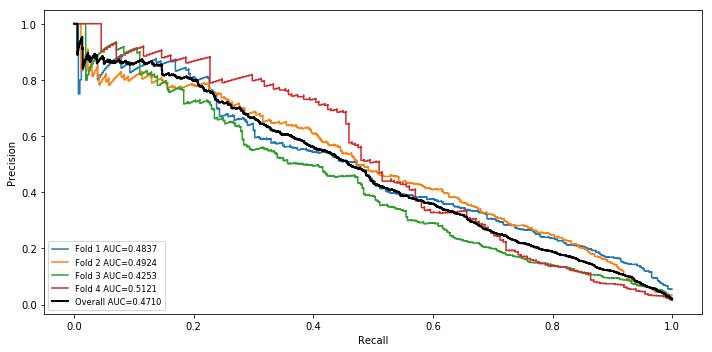

In [161]:
f, axes = plt.subplots(1, 1, figsize=(10, 5))



y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(val_folds):
    print i
    #Xtrain, Xtest = X[train_index], X[test_index]
    Xtrain, Xtest = rez_matrix[feats_names].reset_index(drop=True).loc[train_index], rez_matrix[feats_names].reset_index(drop=True).loc[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes.step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')

f.tight_layout()
plt.show()
f.savefig('result.png')

# А как нам из PR получить информацию по числу сработок? Откуда взять порого для FP? 

In [ ]:
???

## Примеры использования featrue importance, PDP, ICE

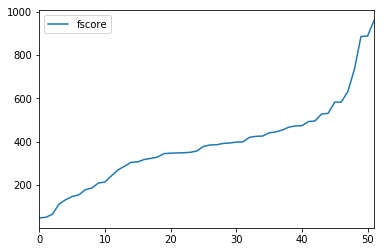

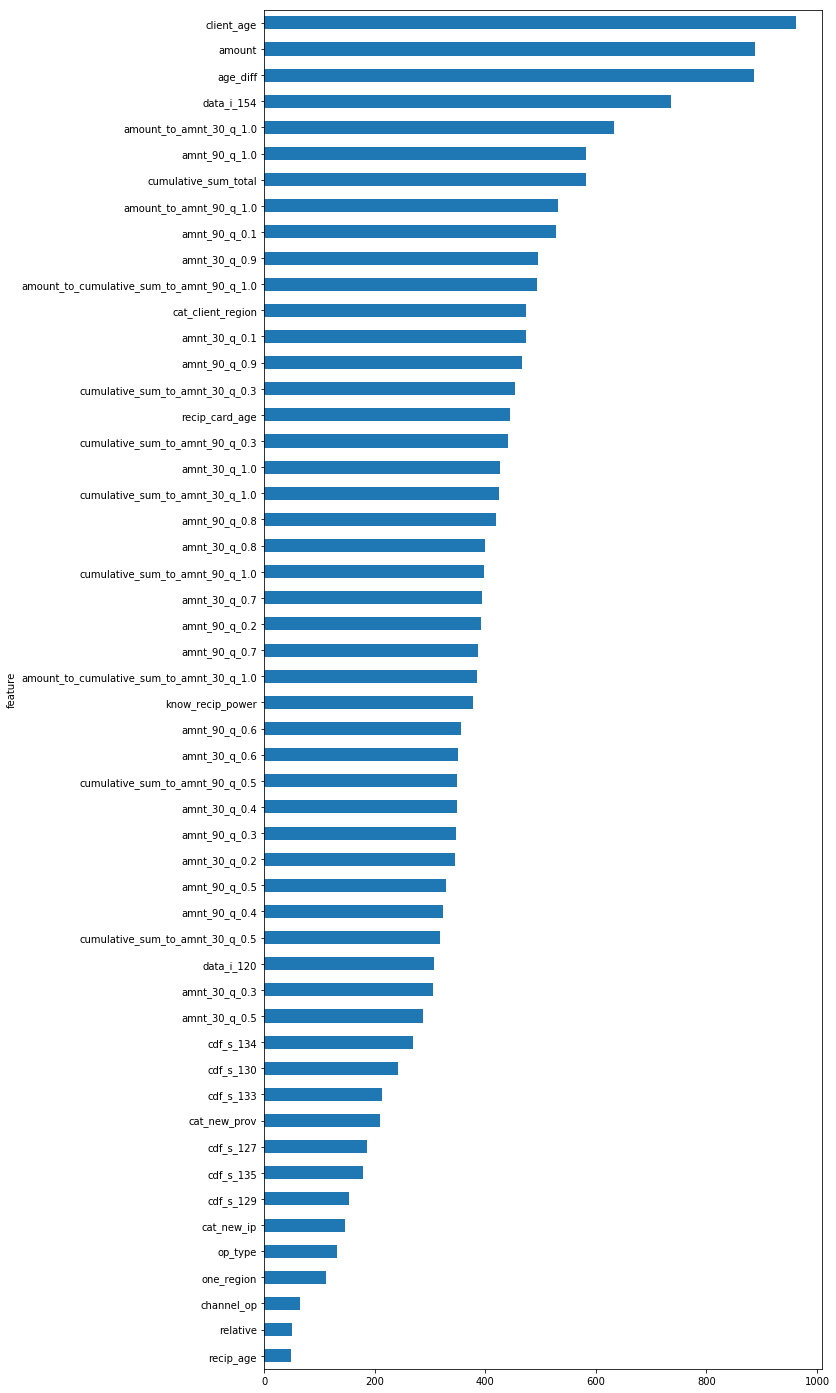

In [162]:
feats_names = rez_matrix.drop(['event_id', 'user_id','event_time', 'custom_mark', 'short_date','TS_indexer', 'lable'], axis=1).columns

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

create_feature_map(feats_names)
    
importance = predictor.booster().get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

feat_df = pd.DataFrame(importance, columns=['feature', 'fscore'])

plt.figure()
feat_df.plot()
feat_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')

## ICE experiments

In [164]:
from pdpbox import pdp

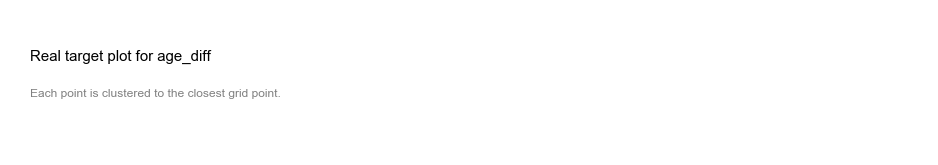

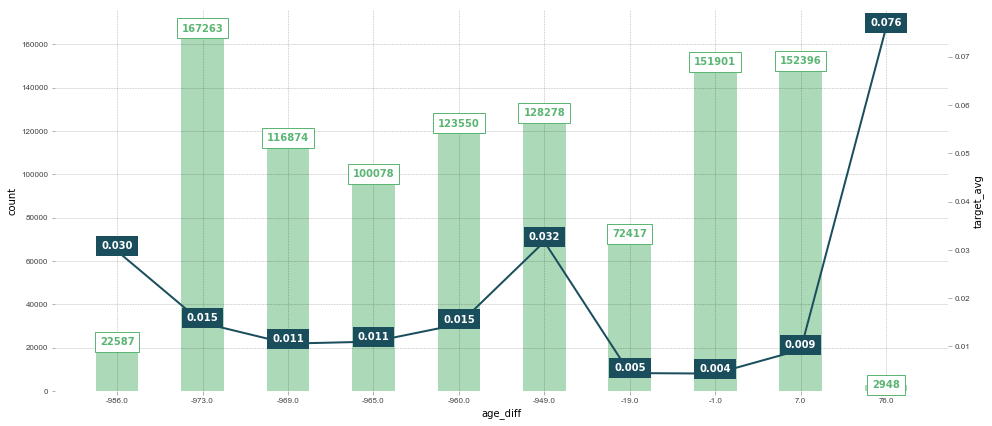

In [514]:
pdp.target_plot(rez_matrix, 'age_diff', 'age_diff', 'lable')

In [544]:
pdp_age_diff = pdp.pdp_isolate(predictor, rez_matrix[feats_names].reset_index(), 'age_diff')

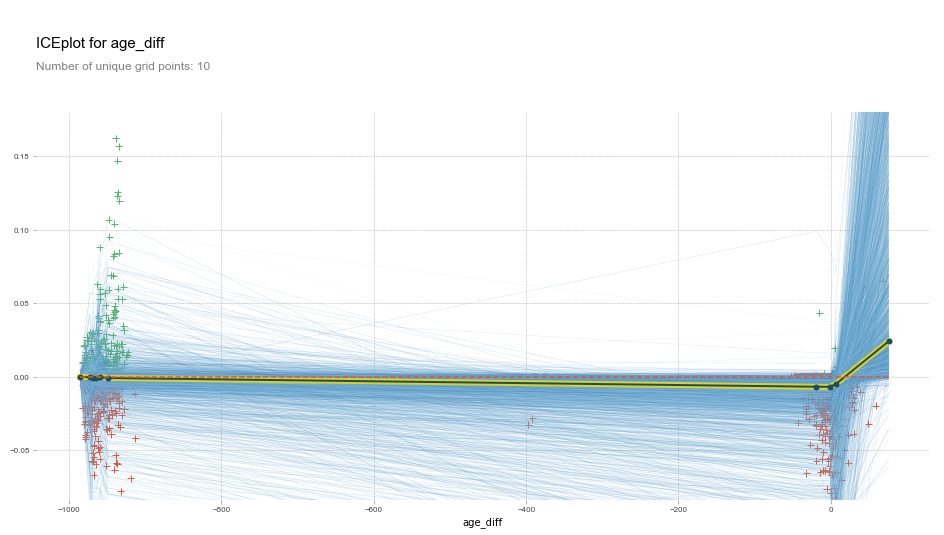

In [549]:
pdp.pdp_plot(pdp_age_diff, 'age_diff', plot_org_pts=True, plot_lines=True, frac_to_plot=10000)

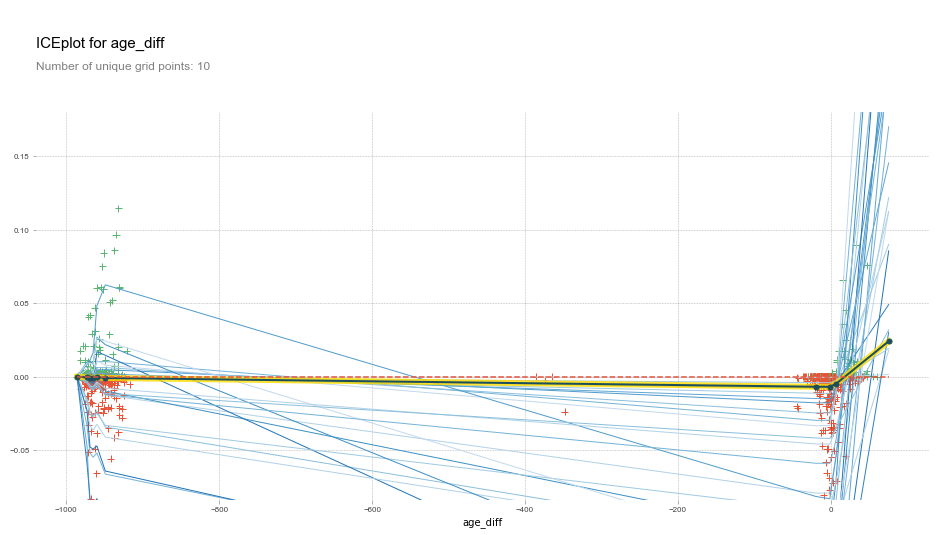

In [551]:
pdp.pdp_plot(pdp_age_diff, 'age_diff', plot_org_pts=True, plot_lines=True, frac_to_plot=3500, cluster=True, n_cluster_centers=15, center=True)

In [174]:
age_sum = pdp.pdp_interact(predictor, rez_matrix[rez_matrix.lable == 1][feats_names].reset_index(drop=True), ['client_age','amount'], num_grid_points=[10, 10])

In [176]:
age_sum.pdp_isolate_out1.ice_lines.actual_preds.max()

0.99152535

In [182]:
age_sum.pdp_isolate_out1.ice_lines.actual_preds.describe()

count    14007.000000
mean     0.424610    
std      0.308601    
min      0.000016    
25%      0.135718    
50%      0.373432    
75%      0.718775    
max      0.991525    
Name: actual_preds, dtype: float64

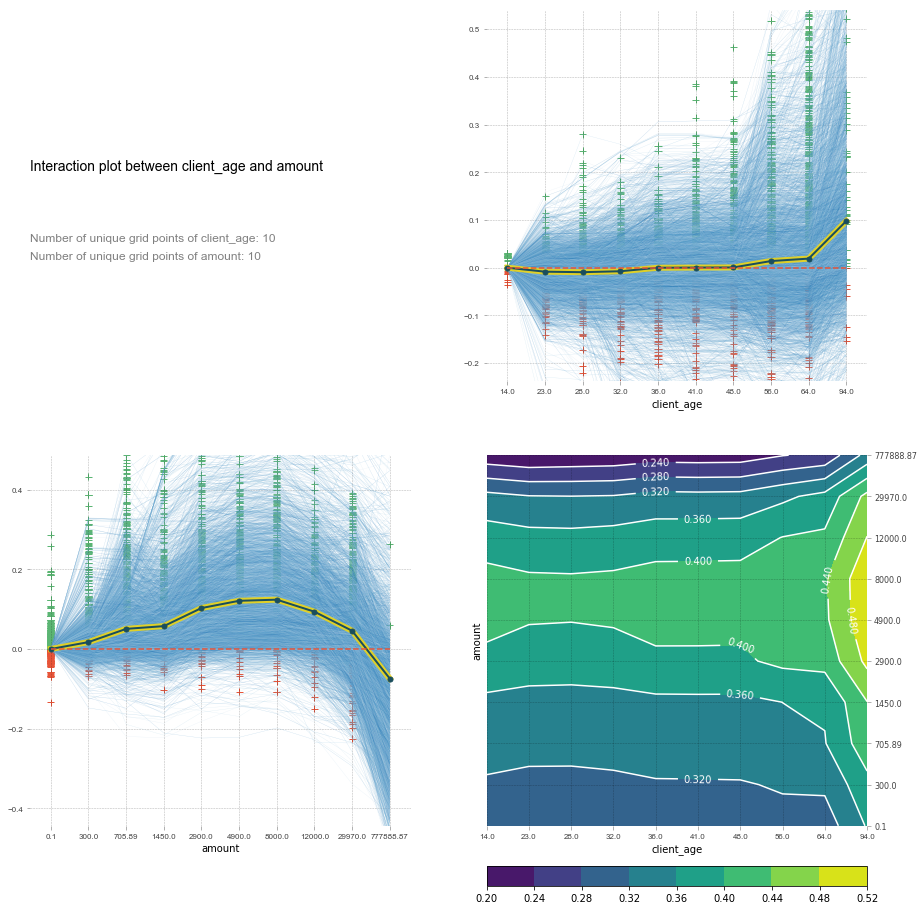

In [181]:
pdp.pdp_interact_plot(age_sum, ['client_age', 'amount'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=5000, x_quantile=True)

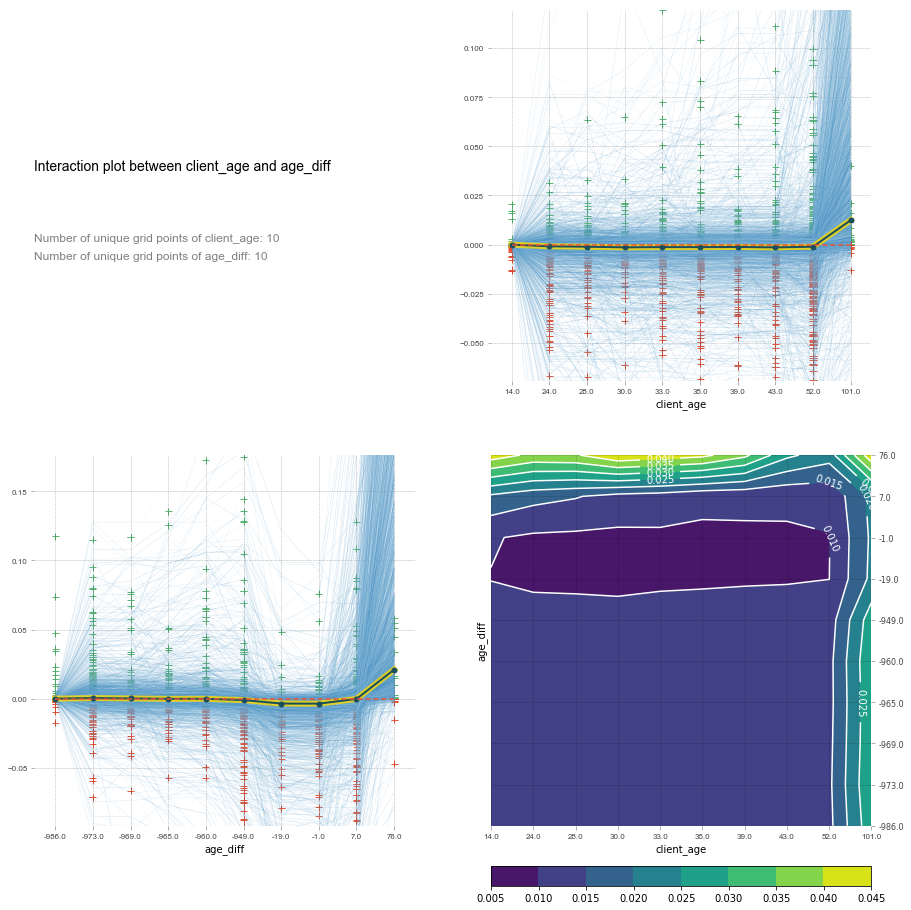

In [170]:
pdp.pdp_interact_plot(inter_age, ['client_age', 'age_diff'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=10000, x_quantile=True)

# Задание - взять и посмотреть какие главниые фичи выделит SHAP-подход, сравнить взаимное влияние аналогичных признаков, прокомеенитровать 2 конкретных предсказания трназакции